# Training a CNN with Residual Block on CIFAR-10
* We will do the following steps in order.
    1. Load and normalizing the CIFAR10 training and test datasets using torchvision
    2. Define a Convolutional Neural Network
    3. Define a loss function
    4. Train the network on the training data
    5. Test the network on the test data

### Load and normalizing the CIFA10 training and test datasets using torchvision

In [1]:
# Loading and normalizing CIFAR-10
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [3]:
# The output of torchvision datasets are PILImage images of range [0,1].
# Transform them th Tensors of normalized range [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


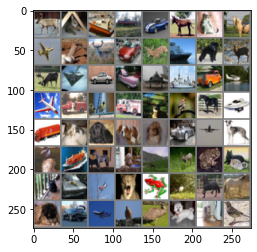

deer, cat, ship, car, 


In [4]:
# display some images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(''.join('%s, ' % classes[labels[j]] for j in range(4)))

### Define a Convolutional Neural Network
* Network Model
    * Convolution - input channel: 3, output channel: 64, kernel_size: 3, padding: 1
    * Residual block - hidden channel: 256, kernel_size: 3, num_block: 2
    * Maxpoling - size: 2, stride: 2
    * Residual block - hidden channel: 256, kernel_size: 3, num_block: 2
    * Maxpoling - size: 2, stride: 2
    * Fully connected layer - in_features: 4096, out_features: 120
    * Fully connected layer - in_features: 120, out_features: 84
    * Fully connected layer - in_features: 84, out_features: 10  
    
* Note
    * Apply ReLU activation function for hidden layers.
    * Residual block have same number of input channels and output channels.


In [5]:
# Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, num_conv, in_dim, out_dim):
        super(ResidualBlock, self).__init__()
        conv = []
        for i in range(num_conv):
            if i == 0:
                conv.append(nn.Conv2d(in_dim, 256, kernel_size=3, stride=1, padding=1))
            elif i == num_conv - 1:
                conv.append(nn.Conv2d(256, out_dim, kernel_size=3, stride=1, padding=1))
            else:
                conv.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1))
            conv.append(nn.ReLU())
        self.conv = nn.ModuleList(conv)
    
    def forward(self, x):
        for i, l in enumerate(self.conv):
            if i == 0: 
                out = l(x)
            else:
                out = l(out)
        return (out + x)
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO: Fill this function
        self.conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.res1 = ResidualBlock(2, 64, 64)
        self.res2 = ResidualBlock(2, 64, 64)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=4096, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        # TODO: Fill this function
        # original image : 3 * 32 * 32
        x = F.relu(self.conv(x))  # 64 * 32 * 32
        x = self.res1(x)  # 64 * 32 * 32
        x = self.pool(x)  # 64 * 16 * 16
        x = self.res2(x)  # 64 * 16 * 16
        x = self.pool(x)  # 64 * 8 * 8
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

net = Net().to(device)

# Test case #1
# - check the default output of model before training
# - make sure that the definition of layers in your model is correct.


### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use Adam optimizer with learning rate 0.001

In [6]:
import torch.optim as optim

# TODO: define a loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Train the network on the training data

In [7]:
### Train the network
print('Start Training ')
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
[1,   500] loss: 1.479
[2,   500] loss: 1.033
[3,   500] loss: 0.849
[4,   500] loss: 0.735
[5,   500] loss: 0.635
[6,   500] loss: 0.572
[7,   500] loss: 0.493
[8,   500] loss: 0.438
[9,   500] loss: 0.386
[10,   500] loss: 0.339
Finished Training


### Test the network on the test data

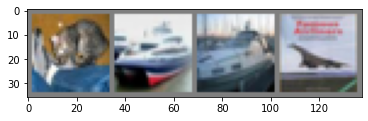

GrondTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [9]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# Test case 2
# - check the predicted output of model after training
# - make sure that the optimizer and its options are correctly defined.

Predicted:    cat  ship  ship plane


In [10]:
# Let us look at how the network performs on the whole dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %


In [11]:
class_correct = [0.0] * 10
class_total = [0.0] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 77 %
Accuracy of   car : 87 %
Accuracy of  bird : 64 %
Accuracy of   cat : 53 %
Accuracy of  deer : 69 %
Accuracy of   dog : 70 %
Accuracy of  frog : 82 %
Accuracy of horse : 74 %
Accuracy of  ship : 83 %
Accuracy of truck : 85 %
